In [ ]:
# add clearml credentials here 
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
# Jupyter
%env CLEARML_API_ACCESS_KEY='YOUR_CLEARML_API_ACCESS_KEY'
%env CLEARML_API_SECRET_KEY='YOUR_CLEARML_API_SECRET_KEY'

In [2]:
# import necessary packages
import os
import gzip
import tempfile
import numpy as np
import matplotlib.pyplot as plt

from clearml import Task
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential

2023-03-15 12:58:29.116981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 12:58:29.277703: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 12:58:29.277730: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 12:58:30.222059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
# connect our jupyter notebook to clearml
task = Task.init(
    project_name='mnist_classification', 
    task_name='dev_experiment'
)

ClearML Task: created new task id=6774fb3d0b37401592382430012ba206
2023-03-15 12:58:42,632 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/8327edd11ea648abada11c985fccd9ab/experiments/6774fb3d0b37401592382430012ba206/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [4]:
# Set script parameters
task_params = {
    'batch_size': 64,
    'nb_classes': 10,
    'nb_epoch': 6,
    'hidden_dim': 512,
}
task_params = task.connect(task_params)

In [5]:
# You can notice that, updating the task_params is traced and updated in ClearML UI
task_params['batch_size'] = 128
task_params['model_loss'] = 'categorical_crossentropy'
task_params['model_optimizer'] = 'rmsprop'

In [6]:
# data initialization
raw_data_dir = os.getcwd() + '/'
data_sources = {
    "training_images": "data/train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "data/t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "data/train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "data/t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

In [7]:
mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(raw_data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(raw_data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

In [8]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

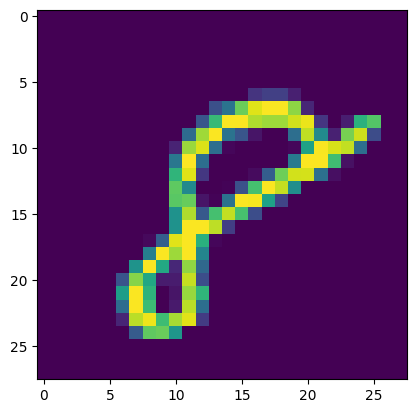

In [9]:
# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
plt.imshow(mnist_image)
# Display the image.
plt.show()

In [10]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [11]:
# convert class vectors to one hot encoded vectors
y_train = np_utils.to_categorical(y_train, task_params['nb_classes'])
y_test = np_utils.to_categorical(y_test, task_params['nb_classes'])

In [12]:
# model initialization
model = Sequential()
model.add(Dense(task_params['hidden_dim'], input_shape=(784,)))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(Dense(task_params['hidden_dim']))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

2023-03-15 12:59:15.984778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-15 12:59:15.984813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (clairvoyantt): /proc/driver/nvidia/version does not exist
2023-03-15 12:59:15.985287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trai

In [13]:
model.compile(loss=task_params['model_loss'],
              optimizer=task_params['model_optimizer'],
              metrics=['accuracy'])

board = TensorBoard(
    histogram_freq=1,
    log_dir=os.path.join(
        tempfile.gettempdir(),
        'histogram_example'
    )
)
model_store = ModelCheckpoint(
    filepath=os.path.join(
        tempfile.gettempdir(),
        'weight.{epoch}.hdf5'
    )
)

model.fit(
    x_train, y_train,
    batch_size=task_params['batch_size'], 
    epochs=task_params['nb_epoch'],
    callbacks=[board, model_store],
    verbose=1, validation_data=(x_test, y_test)
)

Epoch 1/6
469/469 [==============================] - 18s 37ms/step - loss: 0.2318 - accuracy: 0.9293 - val_loss: 0.1007 - val_accuracy: 0.9681
Epoch 2/6
469/469 [==============================] - 18s 38ms/step - loss: 0.0836 - accuracy: 0.9741 - val_loss: 0.0795 - val_accuracy: 0.9759
Epoch 3/6
469/469 [==============================] - 16s 34ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.0754 - val_accuracy: 0.9765
Epoch 4/6
469/469 [==============================] - 16s 33ms/step - loss: 0.0374 - accuracy: 0.9882 - val_loss: 0.0736 - val_accuracy: 0.9795
Epoch 5/6
469/469 [==============================] - 18s 38ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.0734 - val_accuracy: 0.9796
Epoch 6/6
469/469 [==============================] - 18s 37ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0927 - val_accuracy: 0.9764


In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09273628145456314
Test accuracy: 0.9764000177383423


In [15]:
a = model.predict(x_test[0].reshape(1, 784))[0]
a = np.argmax(a)
print(a)

1/1 [==============================] - 0s 100ms/step
7


In [16]:
np.argmax(y_test[0])

7

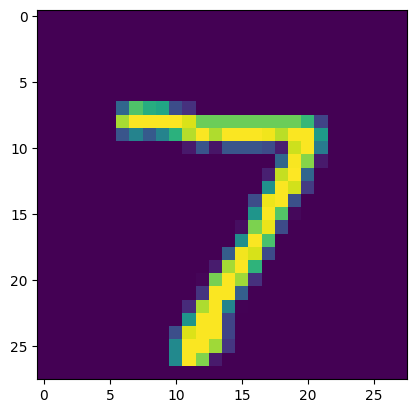

In [17]:
mnist_image = x_test[0, :].reshape(28, 28)
plt.imshow(mnist_image)
# Display the image.
plt.show()